In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
sales_df = pd.read_excel('data/train_sales.xlsx')
promo_df = pd.read_excel('data/train_promo.xlsx')
geography_df = pd.read_excel('data/Атрибуты Customer.xlsx')
weights_df = pd.read_excel('data/Веса DFU.xlsx')

In [3]:
sales_df['Customer'].unique()

array([18, 34,  2, 29, 14,  1], dtype=int64)

In [4]:
sales_df['DFU'].unique()

array(['Рис басмати 500 гр', 'Рис длиннозерный 500 гр',
       'Рис круглозерный 1000 гр', 'Рис круглозерный 500 гр',
       'Рис Жасмин 500 гр', 'Рис для плова 500 гр',
       'Рис длиннозерный 486 гр', 'Гречка Ядрица 1000 гр',
       'Йогурт Постный 180 гр', 'Булгур 300 гр'], dtype=object)

In [5]:
promo_df['DFU'].unique()

array(['Рис длиннозерный 500 гр', 'Рис Жасмин 500 гр',
       'Рис басмати 500 гр', 'Рис для плова 500 гр',
       'Рис круглозерный 1000 гр', 'Йогурт Постный 180 гр',
       'Рис круглозерный 500 гр', 'Булгур 300 гр',
       'Рис длиннозерный 486 гр', 'Киноа 300 гр'], dtype=object)

In [6]:
sales_df[sales_df['DFU'] == 'Рис басмати 500 гр']['Customer'].unique()

array([18, 34,  2, 29, 14,  1], dtype=int64)

In [7]:
promo_df[promo_df['DFU'] == 'Рис басмати 500 гр']['Customer'].unique()

array([41,  6,  3, 13, 26, 15,  1, 40,  7, 45, 21, 12, 32, 24, 35, 36, 22,
       27,  8, 20, 23,  4, 43, 10, 19,  5, 30, 44], dtype=int64)

In [8]:
for dfu_sales in sales_df['DFU'].unique():
    print(f"Кастомеры по продукту {dfu_sales}")
    print(f"train_sales: {sales_df[sales_df['DFU'] == dfu_sales]['Customer'].unique()}")
    print(f"train_promo: {promo_df[promo_df['DFU'] == dfu_sales]['Customer'].unique()}")
    print('\n')

Кастомеры по продукту Рис басмати 500 гр
train_sales: [18 34  2 29 14  1]
train_promo: [41  6  3 13 26 15  1 40  7 45 21 12 32 24 35 36 22 27  8 20 23  4 43 10
 19  5 30 44]


Кастомеры по продукту Рис длиннозерный 500 гр
train_sales: [1]
train_promo: [41 13  1 15 40 45 21 32 12  3  8 26 22 35 27  7 24  6 36 23 20  4 43  5
 19 10 44]


Кастомеры по продукту Рис круглозерный 1000 гр
train_sales: [1]
train_promo: [15 40  1]


Кастомеры по продукту Рис круглозерный 500 гр
train_sales: [1]
train_promo: [41 26 24 32 27 22  6 45 21  3 15 40 13 35  1 12  8 36  7 20 23  4 43 10
  5 19 44 30]


Кастомеры по продукту Рис Жасмин 500 гр
train_sales: [1]
train_promo: [41  6 13 26 15  1 45 21 36  3 40  7 12 22 35 32 24 27  8 20 23  4 43 10
 19  5 30 44]


Кастомеры по продукту Рис для плова 500 гр
train_sales: [1]
train_promo: [41  3 13 12 27 40 32  1 26 35 45 21 22  6 15  7  8 36 20 23  4 43  5 19
 10 30]


Кастомеры по продукту Рис длиннозерный 486 гр
train_sales: [1]
train_promo: [23 15 32 40 20 

In [9]:
sales_df.head(10)

,DFU,Customer,Period,BPV,Total Sell-in
0,Рис басмати 500 гр,18,2017-07-24,0.846000,0.846000
1,Рис басмати 500 гр,18,2017-10-23,1.692000,1.692000
2,Рис басмати 500 гр,18,2018-02-19,2.538000,2.538000
3,Рис басмати 500 гр,18,2018-04-23,1.692000,1.692000
4,Рис басмати 500 гр,18,2019-04-29,4.232100,4.232100
5,Рис басмати 500 гр,18,2019-08-26,2.257200,2.257200
6,Рис басмати 500 гр,18,2019-11-18,2.257200,2.257200
7,Рис басмати 500 гр,18,2020-02-24,2.257200,2.257200
8,Рис басмати 500 гр,18,2020-05-18,2.257200,2.257200
9,Рис басмати 500 гр,18,2020-06-08,2.254407,2.254407


In [10]:
promo_df.head(10)

,Promo,Promo №,Customer,DFU,Promo mechanic,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,First Date of shipment,End Date of shipment,"Discount, %",Units SoD
0,987359,709635,41,Рис длиннозерный 500 гр,395048,2017-12-01,14.0,2017-12-14,14,2017-11-17,2018-01-18,0.15,6216.00000
1,987365,710042,13,Рис длиннозерный 500 гр,395054,2017-12-06,7.0,2017-12-12,21,2017-11-15,2017-12-17,0.20,13511.09062
2,987375,708618,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-02,2017-12-24,0.25,362049.09560
3,987384,709929,15,Рис длиннозерный 500 гр,395054,2017-12-27,7.0,2018-01-02,22,2017-12-11,2018-01-31,0.25,35816.99982
4,987390,709891,40,Рис длиннозерный 500 гр,395054,2018-01-11,14.0,2018-01-24,21,2017-12-26,2018-03-01,0.25,20898.64467
5,987395,708686,45,Рис длиннозерный 500 гр,395054,2018-01-15,14.0,2018-01-28,14,2018-01-01,2018-03-05,0.25,18636.00000
6,987396,708686,21,Рис длиннозерный 500 гр,395054,2018-01-15,14.0,2018-01-28,14,2018-01-01,2018-03-05,0.25,18636.00000
7,987397,708686,21,Рис длиннозерный 500 гр,395054,2018-01-15,14.0,2018-01-28,14,2018-01-01,2018-03-05,0.25,18636.00000
8,987401,709872,32,Рис длиннозерный 500 гр,395054,2018-01-17,7.0,2018-01-23,27,2018-01-01,2018-01-25,0.25,289615.92480
9,987406,709324,12,Рис длиннозерный 500 гр,395052,2018-01-22,21.0,2018-02-11,7,2018-01-08,2018-03-19,0.20,14400.00000


Начнем с обработки выбросов (выбросом считаем, если значение больше 2 сигм - из встречи с зак)

In [11]:
bpv_mean = sales_df["BPV"].mean()
bpv_std = sales_df["BPV"].std()
lower_bound = bpv_mean - 2 * bpv_std
upper_bound = bpv_mean + 2 * bpv_std

bpv_outliers = sales_df[(sales_df["BPV"] < lower_bound) | (sales_df["BPV"] > upper_bound)]

print(f"Outliers in BPV: {len(bpv_outliers)}")
bpv_outliers

Outliers in BPV: 54


,DFU,Customer,Period,BPV,Total Sell-in
773,Рис длиннозерный 500 гр,1,2017-05-22,161.151000,161.151000
776,Рис длиннозерный 500 гр,1,2017-06-12,117.777000,117.777000
782,Рис длиннозерный 500 гр,1,2017-07-24,199.887000,199.887000
784,Рис длиннозерный 500 гр,1,2017-08-07,604.584000,604.584000
791,Рис длиннозерный 500 гр,1,2017-09-25,351.762000,351.762000
800,Рис длиннозерный 500 гр,1,2017-11-27,89.382000,89.382000
801,Рис длиннозерный 500 гр,1,2017-12-04,272.910000,272.910000
807,Рис длиннозерный 500 гр,1,2018-01-15,304.746000,304.746000
812,Рис длиннозерный 500 гр,1,2018-02-19,93.024000,93.024000
813,Рис длиннозерный 500 гр,1,2018-02-26,179.394000,179.394000


Всего 31 выброс, это 1.5% от всех данных, можно удалить

In [12]:
sales_df_cleaned = sales_df[(sales_df["BPV"] >= lower_bound) & (sales_df["BPV"] <= upper_bound)]
sales_df_cleaned = sales_df_cleaned[sales_df_cleaned["BPV"]>= 0]
print(f"Rows after cleaning: {len(sales_df_cleaned)}")

Rows after cleaning: 2062


Посмотрим на выбросы в promo days on shelf

In [13]:
promo_days_mean = promo_df["Promo Days on shelf"].mean()
promo_days_std = promo_df["Promo Days on shelf"].std()
lower_promo_bound = promo_days_mean - 2 * promo_days_std
upper_promo_bound = promo_days_mean + 2 * promo_days_std

promo_days_outliers = promo_df[(promo_df["Promo Days on shelf"] < lower_promo_bound) |
                               (promo_df["Promo Days on shelf"] > upper_promo_bound)]

print(f"Outliers Promo Days on shelf: {len(promo_days_outliers)}")
promo_days_outliers

Outliers Promo Days on shelf: 62


,Promo,Promo №,Customer,DFU,Promo mechanic,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,First Date of shipment,End Date of shipment,"Discount, %",Units SoD
209,988648,709948,1,Рис длиннозерный 500 гр,395054,2019-11-28,37.0,2020-01-03,21,2019-11-12,2020-03-01,0.23,1120000.0
249,988902,709921,3,Рис длиннозерный 500 гр,395048,2020-01-27,40.0,2020-03-06,14,2020-01-01,2020-02-07,0.28,11028.0
283,989110,709594,41,Рис длиннозерный 500 гр,395054,2020-04-01,60.0,2020-05-30,14,2020-03-18,2020-05-05,0.20,24840.0
308,989298,709948,1,Рис длиннозерный 500 гр,395054,2020-11-26,42.0,2021-01-06,16,2020-11-10,2021-01-06,0.20,895656.0
370,989593,709005,3,Рис длиннозерный 500 гр,395048,2020-07-01,57.0,2020-08-26,14,2020-06-18,2020-07-28,0.17,3500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2692,987927,709387,15,Булгур 300 гр,395054,2018-12-07,42.0,2019-01-17,16,2018-11-21,2019-02-02,0.30,11000.0
2748,988392,708616,20,Булгур 300 гр,395048,2019-08-15,38.0,2019-09-21,22,2019-07-20,2019-11-20,0.25,2052.0
2770,988572,709881,15,Булгур 300 гр,395054,2019-10-31,36.0,2019-12-05,22,2019-10-15,2020-01-31,0.25,15000.0
2841,989262,709904,40,Булгур 300 гр,395054,2020-11-30,44.0,2021-01-12,16,2020-11-14,2020-12-29,0.25,108.0


2% от общих, тоже дропнем

In [14]:
promo_df_cleaned = promo_df[(promo_df["Promo Days on shelf"] >= lower_promo_bound) &
                            (promo_df["Promo Days on shelf"] <= upper_promo_bound)]
promo_df_cleaned.drop(columns=["Promo №"], inplace=True)
print(f"Rows after cleaning: {len(promo_df_cleaned)}")

Rows after cleaning: 2953


C:\Users\makuh\AppData\Local\Temp\ipykernel_11852\220232591.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promo_df_cleaned.drop(columns=["Promo №"], inplace=True)


Теперь обработаем пропущенные значения в promo_df

In [15]:
missing_promo_days = promo_df_cleaned[promo_df_cleaned["Promo Days on shelf"].isna()]

missing_promo_days

,Promo,Customer,DFU,Promo mechanic,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,First Date of shipment,End Date of shipment,"Discount, %",Units SoD


а таких у нас нет

Оставим даты не раньше 2017 года

In [16]:
promo_df_cleaned = promo_df_cleaned[promo_df_cleaned["Start Date on shelf"] >= np.datetime64("2017-01-01")]

Переведем Units SoD в тонны

In [17]:
promo_df_cleaned = pd.merge(promo_df_cleaned, weights_df, on="DFU", how="left")
promo_df_cleaned["SoD"] = promo_df_cleaned["Units SoD"] * promo_df_cleaned["Unit weight, tn"]
promo_df_cleaned.drop(columns=["Unit weight, tn"], inplace=True)
promo_df_cleaned

,Promo,Customer,DFU,Promo mechanic,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
0,987359,41,Рис длиннозерный 500 гр,395048,2017-12-01,14.0,2017-12-14,14,2017-11-17,2018-01-18,0.15,6216.00000,7.459200
1,987365,13,Рис длиннозерный 500 гр,395054,2017-12-06,7.0,2017-12-12,21,2017-11-15,2017-12-17,0.20,13511.09062,16.213309
2,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-02,2017-12-24,0.25,362049.09560,434.458915
3,987384,15,Рис длиннозерный 500 гр,395054,2017-12-27,7.0,2018-01-02,22,2017-12-11,2018-01-31,0.25,35816.99982,42.980400
4,987390,40,Рис длиннозерный 500 гр,395054,2018-01-11,14.0,2018-01-24,21,2017-12-26,2018-03-01,0.25,20898.64467,25.078374
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,990735,22,Киноа 300 гр,395054,2021-05-24,7.0,2021-05-30,14,2021-05-10,2021-05-31,0.25,555.00000,0.333000
2947,990794,45,Киноа 300 гр,395054,2021-06-08,14.0,2021-06-21,14,2021-05-25,2021-06-29,0.25,886.00000,0.531600
2948,990804,43,Киноа 300 гр,395054,2021-06-07,14.0,2021-06-20,14,2021-05-24,2021-06-14,0.25,1000.00000,0.600000
2949,990843,4,Киноа 300 гр,395048,2021-06-15,7.0,2021-06-21,7,2021-06-01,2021-06-13,0.27,14775.00000,8.865000


Добавим сезонность в sales

In [18]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

sales_df_cleaned["Season"] = sales_df_cleaned["Period"].apply(get_season)

Объединим с географией и типом Клиента

In [19]:
sales_df_cleaned = pd.merge(sales_df_cleaned, geography_df, left_on="Customer", right_on="Клиент", how="left")
sales_df_cleaned.rename(columns={"Тип": "Type", "География": "Geography"}, inplace=True)

In [20]:
sales_df_cleaned.drop(columns=["Клиент"], inplace=True)
sales_df_cleaned

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography
0,Рис басмати 500 гр,18,2017-07-24,0.846000,0.846000,Summer,Дистрибутор,СНГ
1,Рис басмати 500 гр,18,2017-10-23,1.692000,1.692000,Autumn,Дистрибутор,СНГ
2,Рис басмати 500 гр,18,2018-02-19,2.538000,2.538000,Winter,Дистрибутор,СНГ
3,Рис басмати 500 гр,18,2018-04-23,1.692000,1.692000,Spring,Дистрибутор,СНГ
4,Рис басмати 500 гр,18,2019-04-29,4.232100,4.232100,Spring,Дистрибутор,СНГ
...,...,...,...,...,...,...,...,...
2057,Булгур 300 гр,1,2020-02-24,0.000000,0.032400,Winter,Сеть,Москва
2058,Булгур 300 гр,1,2020-03-02,0.000000,3.211500,Spring,Сеть,Москва
2059,Булгур 300 гр,1,2020-04-06,0.000000,0.421200,Spring,Сеть,Москва
2060,Булгур 300 гр,1,2020-07-06,0.008085,0.008085,Summer,Сеть,Москва


In [21]:
sales_df_cleaned['End of Period'] = sales_df_cleaned['Period'] + pd.Timedelta(days=6)

In [22]:
sales_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DFU            2062 non-null   object        
 1   Customer       2062 non-null   int64         
 2   Period         2062 non-null   datetime64[ns]
 3   BPV            2062 non-null   float64       
 4   Total Sell-in  2062 non-null   float64       
 5   Season         2062 non-null   object        
 6   Type           2062 non-null   object        
 7   Geography      2062 non-null   object        
 8   End of Period  2062 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 145.1+ KB


In [23]:
promo_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2951 entries, 0 to 2950
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Promo                         2951 non-null   int64         
 1   Customer                      2951 non-null   int64         
 2   DFU                           2951 non-null   object        
 3   Promo mechanic                2951 non-null   int64         
 4   Start Date on shelf           2951 non-null   datetime64[ns]
 5   Promo Days on shelf           2951 non-null   float64       
 6   End Date on shelf             2951 non-null   datetime64[ns]
 7   Shipment days to promo start  2951 non-null   int64         
 8   First Date of shipment        2951 non-null   datetime64[ns]
 9   End Date of shipment          2951 non-null   datetime64[ns]
 10  Discount, %                   2951 non-null   float64       
 11  Units SoD                     

In [24]:
promo_cust_1 = promo_df_cleaned[promo_df_cleaned['Customer'] == 1]

In [25]:
promo_cust_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 2 to 2919
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Promo                         183 non-null    int64         
 1   Customer                      183 non-null    int64         
 2   DFU                           183 non-null    object        
 3   Promo mechanic                183 non-null    int64         
 4   Start Date on shelf           183 non-null    datetime64[ns]
 5   Promo Days on shelf           183 non-null    float64       
 6   End Date on shelf             183 non-null    datetime64[ns]
 7   Shipment days to promo start  183 non-null    int64         
 8   First Date of shipment        183 non-null    datetime64[ns]
 9   End Date of shipment          183 non-null    datetime64[ns]
 10  Discount, %                   183 non-null    float64       
 11  Units SoD                     183 no

In [26]:
#sales_df_cleaned.to_excel('sales_df_cleaned.xlsx')

In [27]:
#promo_cust_1.to_excel('promo_cust_1.xlsx')

In [28]:
sales_df_cleaned[sales_df_cleaned['BPV'] != sales_df_cleaned['Total Sell-in']]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period
813,Рис длиннозерный 500 гр,1,2018-05-21,11.535,47.8380,Spring,Сеть,Москва,2018-05-27
814,Рис длиннозерный 500 гр,1,2018-05-28,0.303,236.5500,Spring,Сеть,Москва,2018-06-03
815,Рис длиннозерный 500 гр,1,2018-06-04,14.112,31.3770,Summer,Сеть,Москва,2018-06-10
817,Рис длиннозерный 500 гр,1,2018-06-18,19.614,76.6650,Summer,Сеть,Москва,2018-06-24
818,Рис длиннозерный 500 гр,1,2018-06-25,0.000,267.2940,Summer,Сеть,Москва,2018-07-01
...,...,...,...,...,...,...,...,...,...
2056,Булгур 300 гр,1,2020-02-17,0.000,0.2184,Winter,Сеть,Москва,2020-02-23
2057,Булгур 300 гр,1,2020-02-24,0.000,0.0324,Winter,Сеть,Москва,2020-03-01
2058,Булгур 300 гр,1,2020-03-02,0.000,3.2115,Spring,Сеть,Москва,2020-03-08
2059,Булгур 300 гр,1,2020-04-06,0.000,0.4212,Spring,Сеть,Москва,2020-04-12


In [29]:
sales_df_cleaned[sales_df_cleaned['BPV'] == 0]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period
818,Рис длиннозерный 500 гр,1,2018-06-25,0.0,267.2940,Summer,Сеть,Москва,2018-07-01
831,Рис длиннозерный 500 гр,1,2018-09-24,0.0,301.3200,Autumn,Сеть,Москва,2018-09-30
838,Рис длиннозерный 500 гр,1,2018-11-12,0.0,218.7210,Autumn,Сеть,Москва,2018-11-18
839,Рис длиннозерный 500 гр,1,2018-11-19,0.0,147.3120,Autumn,Сеть,Москва,2018-11-25
840,Рис длиннозерный 500 гр,1,2018-11-26,0.0,166.3344,Autumn,Сеть,Москва,2018-12-02
...,...,...,...,...,...,...,...,...,...
2056,Булгур 300 гр,1,2020-02-17,0.0,0.2184,Winter,Сеть,Москва,2020-02-23
2057,Булгур 300 гр,1,2020-02-24,0.0,0.0324,Winter,Сеть,Москва,2020-03-01
2058,Булгур 300 гр,1,2020-03-02,0.0,3.2115,Spring,Сеть,Москва,2020-03-08
2059,Булгур 300 гр,1,2020-04-06,0.0,0.4212,Spring,Сеть,Москва,2020-04-12


In [30]:
sales_df_cleaned[(sales_df_cleaned['BPV'] == 0) & (sales_df_cleaned['Customer'] != 1)]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period


In [31]:
sales_df_cleaned[(sales_df_cleaned['BPV'] == 0) & (sales_df_cleaned['Total Sell-in'] != 0)]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period
818,Рис длиннозерный 500 гр,1,2018-06-25,0.0,267.2940,Summer,Сеть,Москва,2018-07-01
831,Рис длиннозерный 500 гр,1,2018-09-24,0.0,301.3200,Autumn,Сеть,Москва,2018-09-30
838,Рис длиннозерный 500 гр,1,2018-11-12,0.0,218.7210,Autumn,Сеть,Москва,2018-11-18
839,Рис длиннозерный 500 гр,1,2018-11-19,0.0,147.3120,Autumn,Сеть,Москва,2018-11-25
840,Рис длиннозерный 500 гр,1,2018-11-26,0.0,166.3344,Autumn,Сеть,Москва,2018-12-02
...,...,...,...,...,...,...,...,...,...
2056,Булгур 300 гр,1,2020-02-17,0.0,0.2184,Winter,Сеть,Москва,2020-02-23
2057,Булгур 300 гр,1,2020-02-24,0.0,0.0324,Winter,Сеть,Москва,2020-03-01
2058,Булгур 300 гр,1,2020-03-02,0.0,3.2115,Spring,Сеть,Москва,2020-03-08
2059,Булгур 300 гр,1,2020-04-06,0.0,0.4212,Spring,Сеть,Москва,2020-04-12


In [32]:
sales_df_cleaned[(sales_df_cleaned['BPV'] != sales_df_cleaned['Total Sell-in']) & (sales_df_cleaned['Customer'] != 1)]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period


In [33]:
promo_c1_weekdays = promo_cust_1.copy()

In [34]:
promo_c1_weekdays.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 2 to 2919
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Promo                         183 non-null    int64         
 1   Customer                      183 non-null    int64         
 2   DFU                           183 non-null    object        
 3   Promo mechanic                183 non-null    int64         
 4   Start Date on shelf           183 non-null    datetime64[ns]
 5   Promo Days on shelf           183 non-null    float64       
 6   End Date on shelf             183 non-null    datetime64[ns]
 7   Shipment days to promo start  183 non-null    int64         
 8   First Date of shipment        183 non-null    datetime64[ns]
 9   End Date of shipment          183 non-null    datetime64[ns]
 10  Discount, %                   183 non-null    float64       
 11  Units SoD                     183 no

In [35]:
promo_c1_weekdays.to_excel('promo_c1_weekdays.xlsx')

Есть два датасета pandas:

sales_df_cleaned:
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DFU            2062 non-null   object        
 1   Customer       2062 non-null   int64         
 2   Period         2062 non-null   datetime64[ns]
 3   BPV            2062 non-null   float64       
 4   Total Sell-in  2062 non-null   float64       
 5   Season         2062 non-null   object        
 6   Type           2062 non-null   object        
 7   Geography      2062 non-null   object        
 8   End of Period  2062 non-null   datetime64[ns]

promo_cust_1:
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Promo                         183 non-null    int64         
 1   Customer                      183 non-null    int64         
 2   DFU                           183 non-null    object        
 3   Promo mechanic                183 non-null    int64         
 4   Start Date on shelf           183 non-null    datetime64[ns]
 5   Promo Days on shelf           183 non-null    float64       
 6   End Date on shelf             183 non-null    datetime64[ns]
 7   Shipment days to promo start  183 non-null    int64         
 8   First Date of shipment        183 non-null    datetime64[ns]
 9   End Date of shipment          183 non-null    datetime64[ns]
 10  Discount, %                   183 non-null    float64       
 11  Units SoD                     183 non-null    float64       
 12  SoD                           180 non-null    float64  


 В promo_cust_1 только один Customer = 1, он же есть в первом датасете. Нужно их соединить с помощью merge, но есть несколько проблем:

 Period и End of Period в sales - это понедельник и воскресенье соответственно, однако в promo_cust_1 "Start Date on shelf" может начинаться не с понедельника и заканчиваться (End Date on shelf) не в воскресенье:

 		Promo
weekday	end weekday

Monday -	Sunday	2


Sunday -	Saturday	2

Thursday:

-Friday 1

-Monday	2

-Saturday	1

-Thursday	20

-Wednesday	11

Tuesday:
-Monday	140

-Thursday	3

-Tuesday	1


Нужно соединить по следующей логике:

Если даты периода в строке sales пересекаются с promo не польностью, то нужно разделить на две строки - одна покрывает период без промо-акции, а другая - с ней. Также нужно учесть следующий пункт:

bpv == total sell-in и был промо - в так случае мы считаем, что это ложь и промо не было

# Merge

In [36]:
sales_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DFU            2062 non-null   object        
 1   Customer       2062 non-null   int64         
 2   Period         2062 non-null   datetime64[ns]
 3   BPV            2062 non-null   float64       
 4   Total Sell-in  2062 non-null   float64       
 5   Season         2062 non-null   object        
 6   Type           2062 non-null   object        
 7   Geography      2062 non-null   object        
 8   End of Period  2062 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 145.1+ KB


In [37]:
sales_df_cleaned['Year-Week'] = sales_df_cleaned['Period'].dt.strftime('%Y-%W')
sales_df_cleaned.sort_values('Period')

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week
755,Рис длиннозерный 500 гр,1,2017-01-02,1.03800,1.038000,Winter,Сеть,Москва,2017-01-08,2017-01
1408,Рис для плова 500 гр,1,2017-01-02,1.89000,1.890000,Winter,Сеть,Москва,2017-01-08,2017-01
1181,Рис Жасмин 500 гр,1,2017-01-02,3.34200,3.342000,Winter,Сеть,Москва,2017-01-08,2017-01
121,Рис басмати 500 гр,2,2017-01-02,0.35700,0.357000,Winter,Дистрибутор,ЦФО,2017-01-08,2017-01
961,Рис круглозерный 1000 гр,1,2017-01-02,1.23000,1.230000,Winter,Сеть,Москва,2017-01-08,2017-01
...,...,...,...,...,...,...,...,...,...,...
1180,Рис круглозерный 500 гр,1,2021-06-21,27.40230,32.505300,Summer,Сеть,Москва,2021-06-27,2021-25
323,Рис басмати 500 гр,2,2021-06-21,1.42956,1.429560,Summer,Дистрибутор,ЦФО,2021-06-27,2021-25
1636,Рис для плова 500 гр,1,2021-06-21,0.00000,22.059000,Summer,Сеть,Москва,2021-06-27,2021-25
1860,Рис басмати 500 гр,1,2021-06-21,0.00000,26.155305,Summer,Сеть,Москва,2021-06-27,2021-25


In [38]:
promo_cust_1.columns

Index(['Promo', 'Customer', 'DFU', 'Promo mechanic', 'Start Date on shelf',
       'Promo Days on shelf', 'End Date on shelf',
       'Shipment days to promo start', 'First Date of shipment',
       'End Date of shipment', 'Discount, %', 'Units SoD', 'SoD'],
      dtype='object')

In [39]:
def expand_dates(row):
    return pd.DataFrame({
        'Promo': row['Promo'],
        'Customer': row['Customer'],
        'DFU': row['DFU'],
        'Promo mechanic': row['Promo mechanic'],
        'Start Date on shelf': row['Start Date on shelf'],
        'Promo Days on shelf': row['Promo Days on shelf'],
        'End Date on shelf': row['End Date on shelf'],
        'Shipment days to promo start': row['Shipment days to promo start'],
        'Date': pd.date_range(start=row['First Date of shipment'],
                              end=row['End Date of shipment']),
        'First Date of shipment': row['First Date of shipment'],
        'End Date of shipment': row['End Date of shipment'],
        'Discount, %': row['Discount, %'],
        'Units SoD': row['Units SoD'],
        'SoD': row['SoD'],
    })

# Генерация нового DataFrame с датами
expanded_df = pd.concat(promo_cust_1.apply(expand_dates, axis=1).to_list(), ignore_index=True)

In [40]:
expanded_df.head(25)

,Promo,Customer,DFU,Promo mechanic,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
0,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-02,2017-12-02,2017-12-24,0.25,362049.0956,434.458915
1,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-03,2017-12-02,2017-12-24,0.25,362049.0956,434.458915
2,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-04,2017-12-02,2017-12-24,0.25,362049.0956,434.458915
3,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-05,2017-12-02,2017-12-24,0.25,362049.0956,434.458915
4,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-06,2017-12-02,2017-12-24,0.25,362049.0956,434.458915
5,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-07,2017-12-02,2017-12-24,0.25,362049.0956,434.458915
6,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-08,2017-12-02,2017-12-24,0.25,362049.0956,434.458915
7,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-09,2017-12-02,2017-12-24,0.25,362049.0956,434.458915
8,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-10,2017-12-02,2017-12-24,0.25,362049.0956,434.458915
9,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-11,2017-12-02,2017-12-24,0.25,362049.0956,434.458915


In [41]:
expanded_df['Year-Week'] = expanded_df['Date'].dt.strftime('%Y-%W')

expanded_df.head(25)

,Promo,Customer,DFU,Promo mechanic,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD,Year-Week
0,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-02,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-48
1,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-03,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-48
2,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-04,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-49
3,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-05,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-49
4,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-06,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-49
5,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-07,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-49
6,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-08,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-49
7,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-09,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-49
8,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-10,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-49
9,987375,1,Рис длиннозерный 500 гр,395054,2017-12-18,7.0,2017-12-24,21,2017-12-11,2017-12-02,2017-12-24,0.25,362049.0956,434.458915,2017-50


In [42]:
expanded_unique = expanded_df.drop_duplicates(subset = ['Promo', 'DFU', 'Year-Week'], keep = 'first').reset_index(drop = True)

In [43]:
sales_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2062 entries, 0 to 2061
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DFU            2062 non-null   object        
 1   Customer       2062 non-null   int64         
 2   Period         2062 non-null   datetime64[ns]
 3   BPV            2062 non-null   float64       
 4   Total Sell-in  2062 non-null   float64       
 5   Season         2062 non-null   object        
 6   Type           2062 non-null   object        
 7   Geography      2062 non-null   object        
 8   End of Period  2062 non-null   datetime64[ns]
 9   Year-Week      2062 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 161.2+ KB


In [44]:
expanded_unique.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Promo                         1013 non-null   int64         
 1   Customer                      1013 non-null   int64         
 2   DFU                           1013 non-null   object        
 3   Promo mechanic                1013 non-null   int64         
 4   Start Date on shelf           1013 non-null   datetime64[ns]
 5   Promo Days on shelf           1013 non-null   float64       
 6   End Date on shelf             1013 non-null   datetime64[ns]
 7   Shipment days to promo start  1013 non-null   int64         
 8   Date                          1013 non-null   datetime64[ns]
 9   First Date of shipment        1013 non-null   datetime64[ns]
 10  End Date of shipment          1013 non-null   datetime64[ns]
 11  Discount, %                   

In [45]:
merged = pd.merge(
    left=sales_df_cleaned,
    right=expanded_unique,
    how='left',
    left_on=['Customer', 'DFU', 'Year-Week'],
    right_on=['Customer', 'DFU', 'Year-Week'],
)

In [46]:
merged.to_excel('merged_sales_promo.xlsx')

In [47]:
mask = (merged['BPV'] == merged['Total Sell-in']) & (merged['BPV'] > 0)
cols_to_clean = ['Promo', 'Promo mechanic',
       'Start Date on shelf', 'Promo Days on shelf', 'End Date on shelf',
       'Shipment days to promo start', 'Date', 'First Date of shipment',
       'End Date of shipment', 'Discount, %', 'Units SoD', 'SoD']

merged.loc[mask, cols_to_clean] = np.nan
merged.to_excel('merged_cleaned.xlsx')

# Моделинг, эксперименты

посмотрим на кейсы, когда у нас бпв не равен тотал селл ин и промо не было

In [48]:
merged['Customer'].unique()

array([18, 34,  2, 29, 14,  1], dtype=int64)

In [49]:
merged_bpv_si_conflicts = merged[(merged['BPV'] != merged['Total Sell-in']) & (merged['Promo'].isna() == True)].copy()

In [50]:
merged_bpv_si_conflicts['Customer'].unique()

array([1], dtype=int64)

посторим по конфликтным график - здесь в данных bpv != total sell in, но при этом промо НЕ было

In [51]:
plot_data = merged_bpv_si_conflicts.sort_values(by="Period")
plot_data

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
1092,Рис круглозерный 500 гр,1,2018-11-05,21.813000,21.942000,Autumn,Сеть,Москва,2018-11-11,2018-45,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
1620,Рис для плова 500 гр,1,2018-12-31,1.464600,1.565700,Winter,Сеть,Москва,2019-01-06,2018-53,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
926,Рис длиннозерный 500 гр,1,2019-11-11,1.728000,210.585600,Autumn,Сеть,Москва,2019-11-17,2019-45,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
927,Рис длиннозерный 500 гр,1,2019-11-18,0.000000,257.961600,Autumn,Сеть,Москва,2019-11-24,2019-46,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
928,Рис длиннозерный 500 гр,1,2019-11-25,0.000000,181.382400,Autumn,Сеть,Москва,2019-12-01,2019-47,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,Рис длиннозерный 486 гр,1,2021-05-24,34.205904,39.678336,Spring,Сеть,Москва,2021-05-30,2021-21,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
2019,Рис длиннозерный 486 гр,1,2021-06-07,14.981904,36.179568,Summer,Сеть,Москва,2021-06-13,2021-23,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
2020,Рис длиннозерный 486 гр,1,2021-06-14,0.000000,147.563424,Summer,Сеть,Москва,2021-06-20,2021-24,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
2021,Рис длиннозерный 486 гр,1,2021-06-21,0.000000,101.656512,Summer,Сеть,Москва,2021-06-27,2021-25,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN


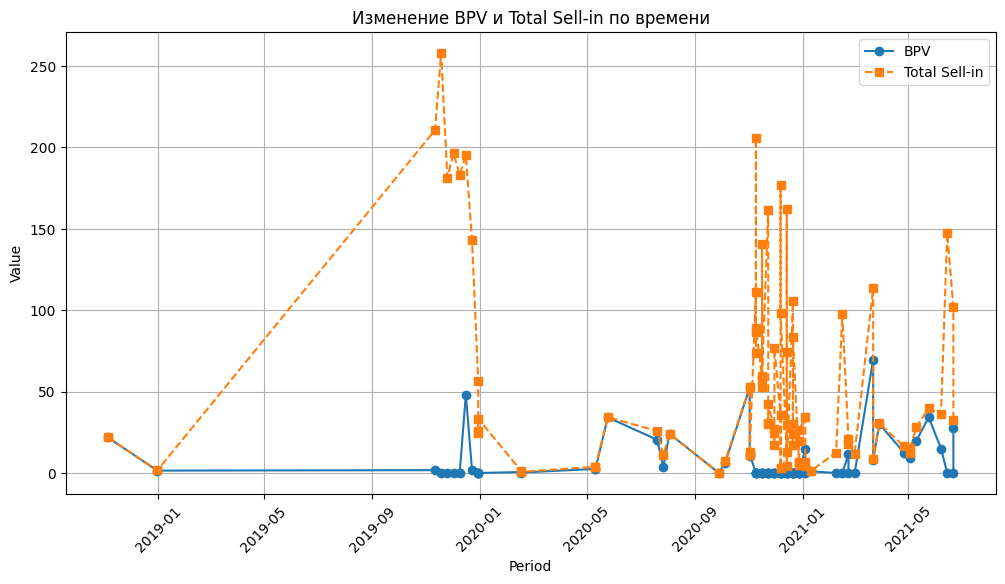

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(plot_data["Period"], plot_data["BPV"], marker='o', label="BPV", linestyle='-')
plt.plot(plot_data["Period"], plot_data["Total Sell-in"], marker='s', label="Total Sell-in", linestyle='--')

plt.xlabel("Period")
plt.ylabel("Value")
plt.title("Изменение BPV и Total Sell-in по времени")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

построим еще для каждого dfu

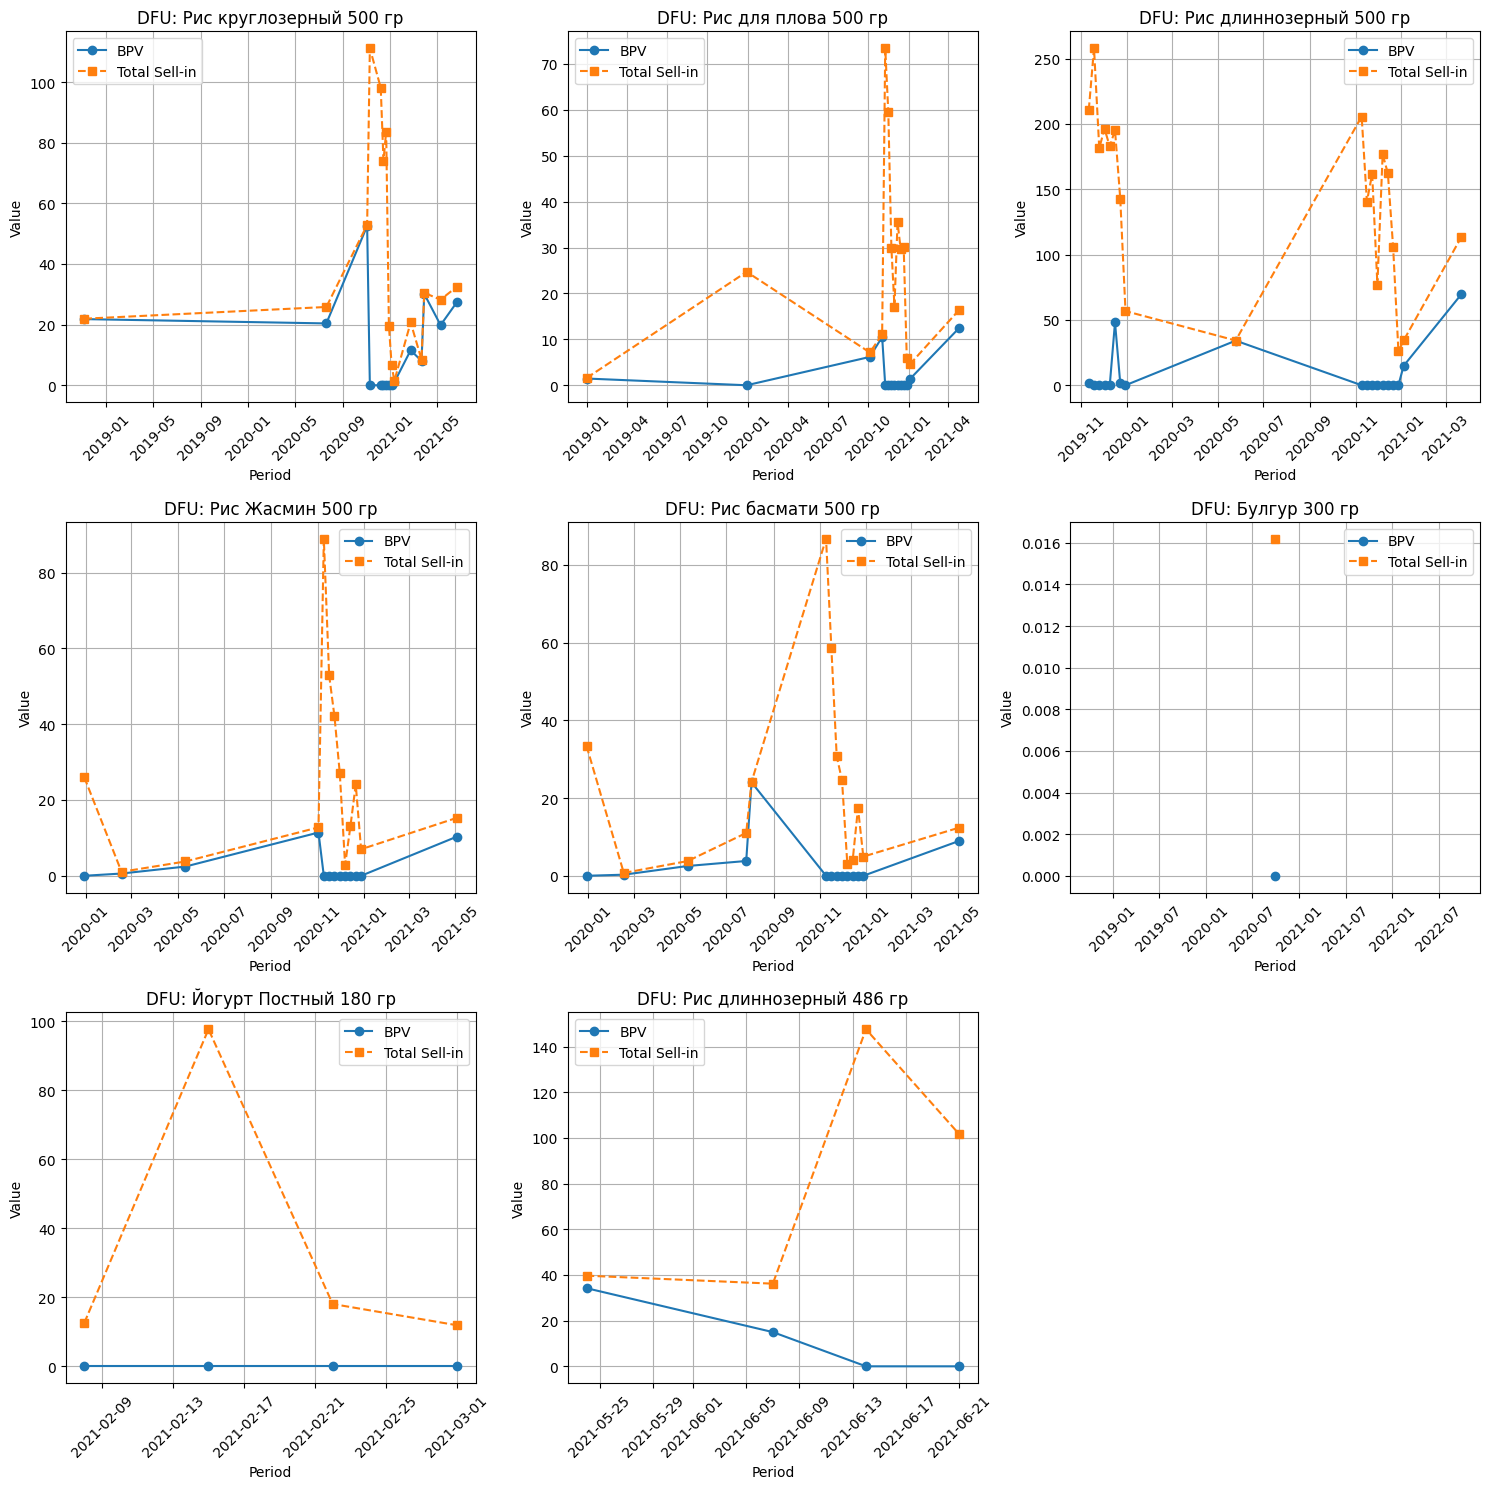

In [53]:
import math

dfu_values = plot_data["DFU"].unique()
num_dfu = len(dfu_values)

num_cols = 3
num_rows = math.ceil(num_dfu / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()

for i, dfu in enumerate(dfu_values):
    ax = axes[i]
    dfu_data = plot_data[plot_data["DFU"] == dfu]
    
    ax.plot(dfu_data["Period"], dfu_data["BPV"], marker='o', linestyle='-', label="BPV")
    ax.plot(dfu_data["Period"], dfu_data["Total Sell-in"], marker='s', linestyle='--', label="Total Sell-in")
    
    ax.set_title(f"DFU: {dfu}")
    ax.set_xlabel("Period")
    ax.set_ylabel("Value")
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [54]:
merged[merged['Promo'].isna() == False]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
813,Рис длиннозерный 500 гр,1,2018-05-21,11.535,47.8380,Spring,Сеть,Москва,2018-05-27,2018-21,...,2018-05-15,7.0,2018-05-21,21.0,2018-05-21,2018-04-29,2018-05-21,0.23,280000.000000,336.0000
814,Рис длиннозерный 500 гр,1,2018-05-21,11.535,47.8380,Spring,Сеть,Москва,2018-05-27,2018-21,...,2018-06-12,7.0,2018-06-18,21.0,2018-05-27,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
815,Рис длиннозерный 500 гр,1,2018-05-28,0.303,236.5500,Spring,Сеть,Москва,2018-06-03,2018-22,...,2018-06-12,7.0,2018-06-18,21.0,2018-05-28,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
816,Рис длиннозерный 500 гр,1,2018-06-04,14.112,31.3770,Summer,Сеть,Москва,2018-06-10,2018-23,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-04,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
818,Рис длиннозерный 500 гр,1,2018-06-18,19.614,76.6650,Summer,Сеть,Москва,2018-06-24,2018-25,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-18,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,Булгур 300 гр,1,2020-02-17,0.000,0.2184,Winter,Сеть,Москва,2020-02-23,2020-07,...,2020-02-25,7.0,2020-03-02,21.0,2020-02-17,2020-02-09,2020-02-20,0.25,2724.666667,1.2261
2228,Булгур 300 гр,1,2020-02-17,0.000,0.2184,Winter,Сеть,Москва,2020-02-23,2020-07,...,2020-03-12,22.0,2020-04-02,21.0,2020-02-20,2020-02-20,2020-04-03,0.25,7136.666667,3.2115
2229,Булгур 300 гр,1,2020-02-24,0.000,0.0324,Winter,Сеть,Москва,2020-03-01,2020-08,...,2020-03-12,22.0,2020-04-02,21.0,2020-02-24,2020-02-20,2020-04-03,0.25,7136.666667,3.2115
2230,Булгур 300 гр,1,2020-03-02,0.000,3.2115,Spring,Сеть,Москва,2020-03-08,2020-09,...,2020-03-12,22.0,2020-04-02,21.0,2020-03-02,2020-02-20,2020-04-03,0.25,7136.666667,3.2115


In [55]:
merged[merged['Promo'].isna() == False].to_excel('merged_si_conflicts.xlsx')

# EDA к моделингу

попробуем сделать следующее: в конфликтных случаях - если у нас bpv != total sell in и промо не было, то просто делаем bpv равным total sell in

In [56]:
df = merged.copy()
df.head(5)

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
0,Рис басмати 500 гр,18,2017-07-24,0.8460,0.8460,Summer,Дистрибутор,СНГ,2017-07-30,2017-30,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
1,Рис басмати 500 гр,18,2017-10-23,1.6920,1.6920,Autumn,Дистрибутор,СНГ,2017-10-29,2017-43,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
2,Рис басмати 500 гр,18,2018-02-19,2.5380,2.5380,Winter,Дистрибутор,СНГ,2018-02-25,2018-08,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
3,Рис басмати 500 гр,18,2018-04-23,1.6920,1.6920,Spring,Дистрибутор,СНГ,2018-04-29,2018-17,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
4,Рис басмати 500 гр,18,2019-04-29,4.2321,4.2321,Spring,Дистрибутор,СНГ,2019-05-05,2019-17,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN


ВОПРОС: в BPV пишем total sell in, поскольку нет данных по промо?

промо сдвинулось. нужно поправку делать. если bpv == 0 и total sell in не равен, то точно было промо. вопрос что делать с граничными. в воскр не бывает отгрузок - нудно смотреть в граничных неделях

In [57]:
df.loc[(df['BPV'] != df['Total Sell-in']) & (df['Promo'].isna()), 'BPV'] = df['Total Sell-in']
df.head(5)

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
0,Рис басмати 500 гр,18,2017-07-24,0.8460,0.8460,Summer,Дистрибутор,СНГ,2017-07-30,2017-30,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
1,Рис басмати 500 гр,18,2017-10-23,1.6920,1.6920,Autumn,Дистрибутор,СНГ,2017-10-29,2017-43,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
2,Рис басмати 500 гр,18,2018-02-19,2.5380,2.5380,Winter,Дистрибутор,СНГ,2018-02-25,2018-08,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
3,Рис басмати 500 гр,18,2018-04-23,1.6920,1.6920,Spring,Дистрибутор,СНГ,2018-04-29,2018-17,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN
4,Рис басмати 500 гр,18,2019-04-29,4.2321,4.2321,Spring,Дистрибутор,СНГ,2019-05-05,2019-17,...,NaT,NaN,NaT,NaN,NaT,NaT,NaT,NaN,NaN,NaN


Почистим данные и подумаем что делать с нанами

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DFU                           2234 non-null   object        
 1   Customer                      2234 non-null   int64         
 2   Period                        2234 non-null   datetime64[ns]
 3   BPV                           2234 non-null   float64       
 4   Total Sell-in                 2234 non-null   float64       
 5   Season                        2234 non-null   object        
 6   Type                          2234 non-null   object        
 7   Geography                     2234 non-null   object        
 8   End of Period                 2234 non-null   datetime64[ns]
 9   Year-Week                     2234 non-null   object        
 10  Promo                         709 non-null    float64       
 11  Promo mechanic                

определять промо по bpv и sell in

In [59]:
df[(df['SoD'].isna()) & (df['Promo'].isna() == False)]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
2117,Йогурт Постный 180 гр,1,2019-03-25,0.0,73.2888,Spring,Сеть,Москва,2019-03-31,2019-12,...,2019-04-11,21.0,2019-05-01,21.0,2019-03-26,2019-03-26,2019-06-25,0.25,162324.0,NaN
2118,Йогурт Постный 180 гр,1,2019-04-01,0.0,19.1916,Spring,Сеть,Москва,2019-04-07,2019-13,...,2019-04-11,21.0,2019-05-01,21.0,2019-04-01,2019-03-26,2019-06-25,0.25,162324.0,NaN
2119,Йогурт Постный 180 гр,1,2019-04-08,0.0,29.7540,Spring,Сеть,Москва,2019-04-14,2019-14,...,2019-04-11,21.0,2019-05-01,21.0,2019-04-08,2019-03-26,2019-06-25,0.25,162324.0,NaN
2120,Йогурт Постный 180 гр,1,2019-04-15,0.0,23.8572,Spring,Сеть,Москва,2019-04-21,2019-15,...,2019-04-11,21.0,2019-05-01,21.0,2019-04-15,2019-03-26,2019-06-25,0.25,162324.0,NaN
2149,Йогурт Постный 180 гр,1,2020-02-24,0.0,90.2664,Winter,Сеть,Москва,2020-03-01,2020-08,...,2020-03-12,22.0,2020-04-02,21.0,2020-02-25,2020-02-25,2020-04-03,0.25,160236.0,NaN
2150,Йогурт Постный 180 гр,1,2020-03-02,0.0,52.6716,Spring,Сеть,Москва,2020-03-08,2020-09,...,2020-03-12,22.0,2020-04-02,21.0,2020-03-02,2020-02-25,2020-04-03,0.25,160236.0,NaN
2151,Йогурт Постный 180 гр,1,2020-03-09,0.0,1.2744,Spring,Сеть,Москва,2020-03-15,2020-10,...,2020-03-12,22.0,2020-04-02,21.0,2020-03-09,2020-02-25,2020-04-03,0.25,160236.0,NaN
2156,Йогурт Постный 180 гр,1,2021-03-22,0.0,15.4008,Spring,Сеть,Москва,2021-03-28,2021-12,...,2021-04-01,31.0,2021-05-01,21.0,2021-03-22,2021-03-11,2021-05-02,0.19,39180.0,NaN
2157,Йогурт Постный 180 гр,1,2021-03-29,0.0,17.7444,Spring,Сеть,Москва,2021-04-04,2021-13,...,2021-04-01,31.0,2021-05-01,21.0,2021-03-29,2021-03-11,2021-05-02,0.19,39180.0,NaN
2158,Йогурт Постный 180 гр,1,2021-04-05,0.0,0.1080,Spring,Сеть,Москва,2021-04-11,2021-14,...,2021-04-01,31.0,2021-05-01,21.0,2021-04-05,2021-03-11,2021-05-02,0.19,39180.0,NaN


In [60]:
df = df.drop(df[(df['SoD'].isna()) & (df['Promo'].notna())].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2224 entries, 0 to 2233
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DFU                           2224 non-null   object        
 1   Customer                      2224 non-null   int64         
 2   Period                        2224 non-null   datetime64[ns]
 3   BPV                           2224 non-null   float64       
 4   Total Sell-in                 2224 non-null   float64       
 5   Season                        2224 non-null   object        
 6   Type                          2224 non-null   object        
 7   Geography                     2224 non-null   object        
 8   End of Period                 2224 non-null   datetime64[ns]
 9   Year-Week                     2224 non-null   object        
 10  Promo                         699 non-null    float64       
 11  Promo mechanic                699 n

In [61]:
promo_columns = ["Promo", "Promo mechanic", "Promo Days on shelf", 
                 "Shipment days to promo start", "Discount, %", 
                 "Units SoD", "SoD"]
df[promo_columns] = df[promo_columns].fillna(0)

date_columns = ["Start Date on shelf", "End Date on shelf", "Date",
                "First Date of shipment", "End Date of shipment"]
df[date_columns] = df[date_columns].fillna(pd.to_datetime("1900-01-01"))

df

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
0,Рис басмати 500 гр,18,2017-07-24,0.846000,0.846000,Summer,Дистрибутор,СНГ,2017-07-30,2017-30,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
1,Рис басмати 500 гр,18,2017-10-23,1.692000,1.692000,Autumn,Дистрибутор,СНГ,2017-10-29,2017-43,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
2,Рис басмати 500 гр,18,2018-02-19,2.538000,2.538000,Winter,Дистрибутор,СНГ,2018-02-25,2018-08,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
3,Рис басмати 500 гр,18,2018-04-23,1.692000,1.692000,Spring,Дистрибутор,СНГ,2018-04-29,2018-17,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
4,Рис басмати 500 гр,18,2019-04-29,4.232100,4.232100,Spring,Дистрибутор,СНГ,2019-05-05,2019-17,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,Булгур 300 гр,1,2020-02-24,0.000000,0.032400,Winter,Сеть,Москва,2020-03-01,2020-08,...,2020-03-12,22.0,2020-04-02,21.0,2020-02-24,2020-02-20,2020-04-03,0.25,7136.666667,3.2115
2230,Булгур 300 гр,1,2020-03-02,0.000000,3.211500,Spring,Сеть,Москва,2020-03-08,2020-09,...,2020-03-12,22.0,2020-04-02,21.0,2020-03-02,2020-02-20,2020-04-03,0.25,7136.666667,3.2115
2231,Булгур 300 гр,1,2020-04-06,0.000000,0.421200,Spring,Сеть,Москва,2020-04-12,2020-14,...,2020-04-21,7.0,2020-04-27,21.0,2020-04-06,2020-03-31,2020-04-16,0.20,936.000000,0.4212
2232,Булгур 300 гр,1,2020-07-06,0.008085,0.008085,Summer,Сеть,Москва,2020-07-12,2020-27,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000


In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2224 entries, 0 to 2233
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DFU                           2224 non-null   object        
 1   Customer                      2224 non-null   int64         
 2   Period                        2224 non-null   datetime64[ns]
 3   BPV                           2224 non-null   float64       
 4   Total Sell-in                 2224 non-null   float64       
 5   Season                        2224 non-null   object        
 6   Type                          2224 non-null   object        
 7   Geography                     2224 non-null   object        
 8   End of Period                 2224 non-null   datetime64[ns]
 9   Year-Week                     2224 non-null   object        
 10  Promo                         2224 non-null   float64       
 11  Promo mechanic                2224 

In [63]:
df = df.drop_duplicates(subset=['DFU', 'Customer', 'Period', 'BPV', 'Total Sell-in'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2052 entries, 0 to 2233
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DFU                           2052 non-null   object        
 1   Customer                      2052 non-null   int64         
 2   Period                        2052 non-null   datetime64[ns]
 3   BPV                           2052 non-null   float64       
 4   Total Sell-in                 2052 non-null   float64       
 5   Season                        2052 non-null   object        
 6   Type                          2052 non-null   object        
 7   Geography                     2052 non-null   object        
 8   End of Period                 2052 non-null   datetime64[ns]
 9   Year-Week                     2052 non-null   object        
 10  Promo                         2052 non-null   float64       
 11  Promo mechanic                2052 

In [64]:
df.to_excel('dataframe.xlsx')

Теперь надо разобраться с SoD

Ожидаемая картина:
1) Во всем датасете SoD + BPV = Total Sell In

Условие соблюдается только в 1500 строках, а не во всем датасете

In [65]:
df[df['SoD'] + df['BPV'] == df['Total Sell-in']]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
0,Рис басмати 500 гр,18,2017-07-24,0.846000,0.846000,Summer,Дистрибутор,СНГ,2017-07-30,2017-30,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
1,Рис басмати 500 гр,18,2017-10-23,1.692000,1.692000,Autumn,Дистрибутор,СНГ,2017-10-29,2017-43,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
2,Рис басмати 500 гр,18,2018-02-19,2.538000,2.538000,Winter,Дистрибутор,СНГ,2018-02-25,2018-08,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
3,Рис басмати 500 гр,18,2018-04-23,1.692000,1.692000,Spring,Дистрибутор,СНГ,2018-04-29,2018-17,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
4,Рис басмати 500 гр,18,2019-04-29,4.232100,4.232100,Spring,Дистрибутор,СНГ,2019-05-05,2019-17,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,Булгур 300 гр,1,2020-01-13,0.012000,0.012000,Winter,Сеть,Москва,2020-01-19,2020-02,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
2221,Булгур 300 гр,1,2020-01-27,0.040500,0.040500,Winter,Сеть,Москва,2020-02-02,2020-04,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000
2230,Булгур 300 гр,1,2020-03-02,0.000000,3.211500,Spring,Сеть,Москва,2020-03-08,2020-09,...,2020-03-12,22.0,2020-04-02,21.0,2020-03-02,2020-02-20,2020-04-03,0.25,7136.666667,3.2115
2232,Булгур 300 гр,1,2020-07-06,0.008085,0.008085,Summer,Сеть,Москва,2020-07-12,2020-27,...,1900-01-01,0.0,1900-01-01,0.0,1900-01-01,1900-01-01,1900-01-01,0.00,0.000000,0.0000


Посмотрим на те случаи, когда условие не соблюдается

Вот тут один ктсти прям ништяк есть

Если не равно , то просто 

In [66]:
df[(df['Promo' ] != 0) & (df['BPV'] + df['SoD'] == df['Total Sell-in'])]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
2230,Булгур 300 гр,1,2020-03-02,0.0,3.2115,Spring,Сеть,Москва,2020-03-08,2020-09,...,2020-03-12,22.0,2020-04-02,21.0,2020-03-02,2020-02-20,2020-04-03,0.25,7136.666667,3.2115


In [67]:
df_conflict = df[df['SoD'] + df['BPV'] != df['Total Sell-in']]
df_conflict

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
813,Рис длиннозерный 500 гр,1,2018-05-21,11.5350,47.8380,Spring,Сеть,Москва,2018-05-27,2018-21,...,2018-05-15,7.0,2018-05-21,21.0,2018-05-21,2018-04-29,2018-05-21,0.23,280000.000000,336.0000
815,Рис длиннозерный 500 гр,1,2018-05-28,0.3030,236.5500,Spring,Сеть,Москва,2018-06-03,2018-22,...,2018-06-12,7.0,2018-06-18,21.0,2018-05-28,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
816,Рис длиннозерный 500 гр,1,2018-06-04,14.1120,31.3770,Summer,Сеть,Москва,2018-06-10,2018-23,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-04,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
818,Рис длиннозерный 500 гр,1,2018-06-18,19.6140,76.6650,Summer,Сеть,Москва,2018-06-24,2018-25,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-18,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
820,Рис длиннозерный 500 гр,1,2018-06-25,0.0000,267.2940,Summer,Сеть,Москва,2018-07-01,2018-26,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-25,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222,Булгур 300 гр,1,2020-02-03,0.0243,0.0687,Winter,Сеть,Москва,2020-02-09,2020-05,...,2019-11-28,28.0,2019-12-25,21.0,2020-02-03,2019-11-12,2020-02-18,0.30,0.000000,0.0000
2224,Булгур 300 гр,1,2020-02-10,0.0000,0.9309,Winter,Сеть,Москва,2020-02-16,2020-06,...,2019-11-28,28.0,2019-12-25,21.0,2020-02-10,2019-11-12,2020-02-18,0.30,0.000000,0.0000
2226,Булгур 300 гр,1,2020-02-17,0.0000,0.2184,Winter,Сеть,Москва,2020-02-23,2020-07,...,2019-11-28,28.0,2019-12-25,21.0,2020-02-17,2019-11-12,2020-02-18,0.30,0.000000,0.0000
2229,Булгур 300 гр,1,2020-02-24,0.0000,0.0324,Winter,Сеть,Москва,2020-03-01,2020-08,...,2020-03-12,22.0,2020-04-02,21.0,2020-02-24,2020-02-20,2020-04-03,0.25,7136.666667,3.2115


Промо в df_conflict - всегда

ВОПРОC: Почему если промо был с нулевым содом, то BPV != Total Sell In и что в таких случаях делать?

In [68]:
df_conflict[df_conflict['SoD'] == 0]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
891,Рис длиннозерный 500 гр,1,2019-06-10,50.2560,79.9344,Summer,Сеть,Москва,2019-06-16,2019-23,...,2019-06-25,7.0,2019-07-01,21.0,2019-06-10,2019-06-09,2019-07-06,0.23,0.0,0.0
893,Рис длиннозерный 500 гр,1,2019-06-17,77.2272,258.4800,Summer,Сеть,Москва,2019-06-23,2019-24,...,2019-06-25,7.0,2019-07-01,21.0,2019-06-17,2019-06-09,2019-07-06,0.23,0.0,0.0
895,Рис длиннозерный 500 гр,1,2019-06-24,51.8976,135.6768,Summer,Сеть,Москва,2019-06-30,2019-25,...,2019-06-25,7.0,2019-07-01,21.0,2019-06-24,2019-06-09,2019-07-06,0.23,0.0,0.0
1406,Рис Жасмин 500 гр,1,2019-11-11,0.4512,19.7118,Autumn,Сеть,Москва,2019-11-17,2019-45,...,2019-10-03,29.0,2019-10-31,21.0,2019-11-11,2019-09-17,2019-12-25,0.25,0.0,0.0
1407,Рис Жасмин 500 гр,1,2019-11-18,0.0000,248.5887,Autumn,Сеть,Москва,2019-11-24,2019-46,...,2019-10-03,29.0,2019-10-31,21.0,2019-11-18,2019-09-17,2019-12-25,0.25,0.0,0.0
1408,Рис Жасмин 500 гр,1,2019-11-25,0.0000,85.7061,Autumn,Сеть,Москва,2019-12-01,2019-47,...,2019-10-03,29.0,2019-10-31,21.0,2019-11-25,2019-09-17,2019-12-25,0.25,0.0,0.0
1409,Рис Жасмин 500 гр,1,2019-12-02,0.0000,9.6291,Winter,Сеть,Москва,2019-12-08,2019-48,...,2019-10-03,29.0,2019-10-31,21.0,2019-12-02,2019-09-17,2019-12-25,0.25,0.0,0.0
1410,Рис Жасмин 500 гр,1,2019-12-09,0.0000,45.6108,Winter,Сеть,Москва,2019-12-15,2019-49,...,2019-10-03,29.0,2019-10-31,21.0,2019-12-09,2019-09-17,2019-12-25,0.25,0.0,0.0
1411,Рис Жасмин 500 гр,1,2019-12-16,13.7301,54.8643,Winter,Сеть,Москва,2019-12-22,2019-50,...,2019-10-03,29.0,2019-10-31,21.0,2019-12-16,2019-09-17,2019-12-25,0.25,0.0,0.0
1412,Рис Жасмин 500 гр,1,2019-12-23,0.0000,13.3710,Winter,Сеть,Москва,2019-12-29,2019-51,...,2019-10-03,29.0,2019-10-31,21.0,2019-12-23,2019-09-17,2019-12-25,0.25,0.0,0.0


ВОПРОС: Почему здесь не выполняется условие и как его обрабатывать ?

In [69]:
df_conflict[df_conflict['SoD'] != 0]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
813,Рис длиннозерный 500 гр,1,2018-05-21,11.535,47.8380,Spring,Сеть,Москва,2018-05-27,2018-21,...,2018-05-15,7.0,2018-05-21,21.0,2018-05-21,2018-04-29,2018-05-21,0.23,280000.000000,336.0000
815,Рис длиннозерный 500 гр,1,2018-05-28,0.303,236.5500,Spring,Сеть,Москва,2018-06-03,2018-22,...,2018-06-12,7.0,2018-06-18,21.0,2018-05-28,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
816,Рис длиннозерный 500 гр,1,2018-06-04,14.112,31.3770,Summer,Сеть,Москва,2018-06-10,2018-23,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-04,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
818,Рис длиннозерный 500 гр,1,2018-06-18,19.614,76.6650,Summer,Сеть,Москва,2018-06-24,2018-25,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-18,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
820,Рис длиннозерный 500 гр,1,2018-06-25,0.000,267.2940,Summer,Сеть,Москва,2018-07-01,2018-26,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-25,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2204,Булгур 300 гр,1,2019-09-30,0.000,0.9351,Autumn,Сеть,Москва,2019-10-06,2019-39,...,2019-08-08,29.0,2019-09-05,21.0,2019-09-30,2019-07-23,2019-10-30,0.25,10336.000000,4.6512
2206,Булгур 300 гр,1,2019-10-07,0.000,0.3519,Autumn,Сеть,Москва,2019-10-13,2019-40,...,2019-08-08,29.0,2019-09-05,21.0,2019-10-07,2019-07-23,2019-10-30,0.25,10336.000000,4.6512
2208,Булгур 300 гр,1,2019-10-14,0.000,0.5583,Autumn,Сеть,Москва,2019-10-20,2019-41,...,2019-08-08,29.0,2019-09-05,21.0,2019-10-14,2019-07-23,2019-10-30,0.25,10336.000000,4.6512
2229,Булгур 300 гр,1,2020-02-24,0.000,0.0324,Winter,Сеть,Москва,2020-03-01,2020-08,...,2020-03-12,22.0,2020-04-02,21.0,2020-02-24,2020-02-20,2020-04-03,0.25,7136.666667,3.2115


In [70]:
df_conflict[df_conflict['SoD'] > df_conflict['Total Sell-in']]

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week,...,Start Date on shelf,Promo Days on shelf,End Date on shelf,Shipment days to promo start,Date,First Date of shipment,End Date of shipment,"Discount, %",Units SoD,SoD
813,Рис длиннозерный 500 гр,1,2018-05-21,11.535,47.8380,Spring,Сеть,Москва,2018-05-27,2018-21,...,2018-05-15,7.0,2018-05-21,21.0,2018-05-21,2018-04-29,2018-05-21,0.23,280000.000000,336.0000
816,Рис длиннозерный 500 гр,1,2018-06-04,14.112,31.3770,Summer,Сеть,Москва,2018-06-10,2018-23,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-04,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
818,Рис длиннозерный 500 гр,1,2018-06-18,19.614,76.6650,Summer,Сеть,Москва,2018-06-24,2018-25,...,2018-06-12,7.0,2018-06-18,21.0,2018-06-18,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
823,Рис длиннозерный 500 гр,1,2018-07-02,14.025,74.3340,Summer,Сеть,Москва,2018-07-08,2018-27,...,2018-06-12,7.0,2018-06-18,21.0,2018-07-02,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
826,Рис длиннозерный 500 гр,1,2018-07-09,13.449,21.8580,Summer,Сеть,Москва,2018-07-15,2018-28,...,2018-06-12,7.0,2018-06-18,21.0,2018-07-09,2018-05-27,2018-07-27,0.23,195000.000000,234.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2202,Булгур 300 гр,1,2019-09-23,0.000,2.3199,Autumn,Сеть,Москва,2019-09-29,2019-38,...,2019-08-08,29.0,2019-09-05,21.0,2019-09-23,2019-07-23,2019-10-30,0.25,10336.000000,4.6512
2204,Булгур 300 гр,1,2019-09-30,0.000,0.9351,Autumn,Сеть,Москва,2019-10-06,2019-39,...,2019-08-08,29.0,2019-09-05,21.0,2019-09-30,2019-07-23,2019-10-30,0.25,10336.000000,4.6512
2206,Булгур 300 гр,1,2019-10-07,0.000,0.3519,Autumn,Сеть,Москва,2019-10-13,2019-40,...,2019-08-08,29.0,2019-09-05,21.0,2019-10-07,2019-07-23,2019-10-30,0.25,10336.000000,4.6512
2208,Булгур 300 гр,1,2019-10-14,0.000,0.5583,Autumn,Сеть,Москва,2019-10-20,2019-41,...,2019-08-08,29.0,2019-09-05,21.0,2019-10-14,2019-07-23,2019-10-30,0.25,10336.000000,4.6512


In [71]:
exceeding_rows = df_conflict[df_conflict['SoD'] > df_conflict['Total Sell-in']]
average_exceedance = (exceeding_rows["SoD"] / exceeding_rows["Total Sell-in"]).mean()

print(f"SoD превышает Total Sell In: {exceeding_rows.shape[0] / df_conflict.shape[0]:.2%}")
print(f"SoD превышает Total Sell In в среднем: {average_exceedance:.2f} раз")

SoD превышает Total Sell In: 89.49%
SoD превышает Total Sell In в среднем: 16.75 раз


# Построим еще общий график и посмотрим как себя вели total sell in и bpv на протяжении всего времени

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2052 entries, 0 to 2233
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DFU                           2052 non-null   object        
 1   Customer                      2052 non-null   int64         
 2   Period                        2052 non-null   datetime64[ns]
 3   BPV                           2052 non-null   float64       
 4   Total Sell-in                 2052 non-null   float64       
 5   Season                        2052 non-null   object        
 6   Type                          2052 non-null   object        
 7   Geography                     2052 non-null   object        
 8   End of Period                 2052 non-null   datetime64[ns]
 9   Year-Week                     2052 non-null   object        
 10  Promo                         2052 non-null   float64       
 11  Promo mechanic                2052 

## Как в целом менялся total sell in и bpv с течением времени

In [73]:
import plotly.express as px

plot_data = df.sort_values(by="Period")

fig1 = px.line(plot_data[plot_data['Promo'] == 0], x="Period", y=["BPV", "Total Sell-in"], 
              labels={"value": "Значение", "Period": "Дата"},
              title="Изменение BPV и Total Sell-in во времени, не было промо")

fig2 = px.line(plot_data[plot_data['Promo'] != 0], x="Period", y=["BPV", "Total Sell-in"], 
              labels={"value": "Значение", "Period": "Дата"},
              title="Изменение BPV и Total Sell-in во времени, было промо")

fig1.show()
fig2.show()

In [74]:
plot_data[plot_data['Promo'] != 0]['Customer'].value_counts()

Customer
1    553
Name: count, dtype: int64

In [75]:
import plotly.express as px

fig1 = px.line(plot_data[(plot_data['Promo'] == 0) & (plot_data['Customer'] == 1)], x="Period", y=["BPV", "Total Sell-in"], 
              labels={"value": "Значение", "Period": "Дата"},
              title="Customer 1: Изменение BPV и Total Sell-in во времени, не было промо")

fig2 = px.line(plot_data[(plot_data['Promo'] != 0) & (plot_data['Customer'] == 1)], x="Period", y=["BPV", "Total Sell-in"], 
              labels={"value": "Значение", "Period": "Дата"},
              title="Customer 1: Изменение BPV и Total Sell-in во времени, было промо")

fig1.show()
fig2.show()

In [76]:
sales_df_cleaned.sort_values(by="Period")

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week
755,Рис длиннозерный 500 гр,1,2017-01-02,1.03800,1.038000,Winter,Сеть,Москва,2017-01-08,2017-01
1408,Рис для плова 500 гр,1,2017-01-02,1.89000,1.890000,Winter,Сеть,Москва,2017-01-08,2017-01
1181,Рис Жасмин 500 гр,1,2017-01-02,3.34200,3.342000,Winter,Сеть,Москва,2017-01-08,2017-01
121,Рис басмати 500 гр,2,2017-01-02,0.35700,0.357000,Winter,Дистрибутор,ЦФО,2017-01-08,2017-01
961,Рис круглозерный 1000 гр,1,2017-01-02,1.23000,1.230000,Winter,Сеть,Москва,2017-01-08,2017-01
...,...,...,...,...,...,...,...,...,...,...
1180,Рис круглозерный 500 гр,1,2021-06-21,27.40230,32.505300,Summer,Сеть,Москва,2021-06-27,2021-25
323,Рис басмати 500 гр,2,2021-06-21,1.42956,1.429560,Summer,Дистрибутор,ЦФО,2021-06-27,2021-25
1636,Рис для плова 500 гр,1,2021-06-21,0.00000,22.059000,Summer,Сеть,Москва,2021-06-27,2021-25
1860,Рис басмати 500 гр,1,2021-06-21,0.00000,26.155305,Summer,Сеть,Москва,2021-06-27,2021-25


In [77]:
import plotly.graph_objects as go

customer_data = sales_df_cleaned[sales_df_cleaned['Customer'] == 1]

dfu_list = customer_data['DFU'].unique()

for dfu in dfu_list:
    dfu_data = customer_data[customer_data['DFU'] == dfu]
    
    dfu_data = dfu_data.sort_values(by='Period')
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=dfu_data['Period'], y=dfu_data['BPV'], mode='lines+markers', name='BPV',
        line=dict(color='blue', width=2)
    ))
    fig.add_trace(go.Scatter(
        x=dfu_data['Period'], y=dfu_data['Total Sell-in'], mode='lines+markers', name='Total-sell-in',
        line=dict(color='green', width=2)
    ))
    
    zero_bpv_points = dfu_data[dfu_data['BPV'] == 0]
    fig.add_trace(go.Scatter(
        x=zero_bpv_points['Period'], y=zero_bpv_points['BPV'], mode='markers',
        name='BPV = 0', marker=dict(color='red', size=8)
    ))
    
    min_date = dfu_data['Period'].min()
    
    fig.update_layout(
        title=f'Customer 1, DFU {dfu}<br>BPV, Total-sell-in, and SoD with BPV = 0 highlighted',
        xaxis_title='Period',
        yaxis_title='Values',
        template='plotly_white',
        width=1500,
        height=600,
        legend=dict(x=0.02, y=0.98),
        hovermode='x unified'
    )
    
    fig.update_xaxes(range=['2017-01-01', '2021-07-15'])
    
    fig.show()

In [78]:
import plotly.graph_objects as go

customer_list = sales_df_cleaned['Customer'].unique()

for customer in customer_list:
    customer_data = sales_df_cleaned[sales_df_cleaned['Customer'] == customer]
    
    dfu_list = customer_data['DFU'].unique()

    for dfu in dfu_list:
        dfu_data = customer_data[customer_data['DFU'] == dfu]
        
        dfu_data = dfu_data.sort_values(by='Period')
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=dfu_data['Period'], y=dfu_data['BPV'], mode='lines+markers', name='BPV',
            line=dict(color='blue', width=2)
        ))
        fig.add_trace(go.Scatter(
            x=dfu_data['Period'], y=dfu_data['Total Sell-in'], mode='lines+markers', name='Total-sell-in',
            line=dict(color='green', width=2)
        ))
        
        zero_bpv_points = dfu_data[dfu_data['BPV'] == 0]
        fig.add_trace(go.Scatter(
            x=zero_bpv_points['Period'], y=zero_bpv_points['BPV'], mode='markers',
            name='BPV = 0', marker=dict(color='red', size=8)
        ))
        
        fig.update_layout(
            title=f'Customer {customer}, DFU {dfu}<br>BPV, Total-sell-in, and SoD with BPV = 0 highlighted',
            xaxis_title='Period',
            yaxis_title='Values',
            template='plotly_white',
            width=1500,
            height=600,
            legend=dict(x=0.02, y=0.98),
            hovermode='x unified'
        )
        
        fig.update_xaxes(range=['2017-01-01', '2021-07-15'])
        
        fig.show()

In [79]:
sales_df_cleaned = sales_df_cleaned[sales_df_cleaned['Period'] >= '2018-04-23']
sales_df_cleaned

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week
3,Рис басмати 500 гр,18,2018-04-23,1.692000,1.692000,Spring,Дистрибутор,СНГ,2018-04-29,2018-17
4,Рис басмати 500 гр,18,2019-04-29,4.232100,4.232100,Spring,Дистрибутор,СНГ,2019-05-05,2019-17
5,Рис басмати 500 гр,18,2019-08-26,2.257200,2.257200,Summer,Дистрибутор,СНГ,2019-09-01,2019-34
6,Рис басмати 500 гр,18,2019-11-18,2.257200,2.257200,Autumn,Дистрибутор,СНГ,2019-11-24,2019-46
7,Рис басмати 500 гр,18,2020-02-24,2.257200,2.257200,Winter,Дистрибутор,СНГ,2020-03-01,2020-08
...,...,...,...,...,...,...,...,...,...,...
2057,Булгур 300 гр,1,2020-02-24,0.000000,0.032400,Winter,Сеть,Москва,2020-03-01,2020-08
2058,Булгур 300 гр,1,2020-03-02,0.000000,3.211500,Spring,Сеть,Москва,2020-03-08,2020-09
2059,Булгур 300 гр,1,2020-04-06,0.000000,0.421200,Spring,Сеть,Москва,2020-04-12,2020-14
2060,Булгур 300 гр,1,2020-07-06,0.008085,0.008085,Summer,Сеть,Москва,2020-07-12,2020-27


In [80]:
customer_products = sales_df_cleaned.groupby('Customer')['DFU'].unique().reset_index()
customer_products

,Customer,DFU
0,1,"[Рис длиннозерный 500 гр, Рис круглозерный 100..."
1,2,[Рис басмати 500 гр]
2,14,[Рис басмати 500 гр]
3,18,[Рис басмати 500 гр]
4,29,[Рис басмати 500 гр]
5,34,[Рис басмати 500 гр]


In [81]:
last_sales_dates = sales_df_cleaned.groupby(['DFU', 'Customer'])['Period'].max().reset_index()

min_last_period = last_sales_dates['Period'].min()

earliest_products = last_sales_dates[last_sales_dates['Period'] == min_last_period]

next_10_earliest = (
    last_sales_dates[last_sales_dates['Period'] > min_last_period]
    .sort_values('Period')
    .head(10)
)

final_df = pd.concat([earliest_products, next_10_earliest])

final_df

,DFU,Customer,Period
12,Рис круглозерный 1000 гр,1,2018-09-17
0,Булгур 300 гр,1,2020-09-28
6,Рис басмати 500 гр,18,2021-02-22
1,Йогурт Постный 180 гр,1,2021-04-05
10,Рис длиннозерный 500 гр,1,2021-06-07
2,Рис Жасмин 500 гр,1,2021-06-21
3,Рис басмати 500 гр,1,2021-06-21
4,Рис басмати 500 гр,2,2021-06-21
5,Рис басмати 500 гр,14,2021-06-21
7,Рис басмати 500 гр,29,2021-06-21


In [83]:
dfu_customer_counts = sales_df_cleaned.groupby(['DFU', 'Customer']).size().reset_index(name='Record Count')

final_df = final_df.merge(dfu_customer_counts, on=['DFU', 'Customer'], how='left')
final_df

,DFU,Customer,Period,Record Count_x,Record Count_y
0,Рис круглозерный 1000 гр,1,2018-09-17,15,15
1,Булгур 300 гр,1,2020-09-28,52,52
2,Рис басмати 500 гр,18,2021-02-22,9,9
3,Йогурт Постный 180 гр,1,2021-04-05,72,72
4,Рис длиннозерный 500 гр,1,2021-06-07,151,151
5,Рис Жасмин 500 гр,1,2021-06-21,164,164
6,Рис басмати 500 гр,1,2021-06-21,164,164
7,Рис басмати 500 гр,2,2021-06-21,138,138
8,Рис басмати 500 гр,14,2021-06-21,148,148
9,Рис басмати 500 гр,29,2021-06-21,151,151


С правой стороны кикаем:

Рис круглозерный 1000 гр, 1
Булгур 300 гр, 1
Рис басмати 500 гр,18
Йогурт Постный 180 гр, 1 ? потенциально - дропаем 72 записи чтобы получить 90, но при этом отказываемся от dfu

максимальноая дата по которой берем датасет - 07.06.2021




что делать с редкими продажами??

Кикаем:

DFU «Гречка Ядрица 1000 гр»

DFU «Йогурт Постный 180 гр»

DFU «Рис Круглозёрный 1000 гр»

DFU «Булгур 300 гр»

In [85]:
sales_df_cleaned.shape

(1479, 10)

In [86]:
sales_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1479 entries, 3 to 2061
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DFU            1479 non-null   object        
 1   Customer       1479 non-null   int64         
 2   Period         1479 non-null   datetime64[ns]
 3   BPV            1479 non-null   float64       
 4   Total Sell-in  1479 non-null   float64       
 5   Season         1479 non-null   object        
 6   Type           1479 non-null   object        
 7   Geography      1479 non-null   object        
 8   End of Period  1479 non-null   datetime64[ns]
 9   Year-Week      1479 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 127.1+ KB


In [90]:
sales_df_cleaned[sales_df_cleaned['DFU'] == "Йогурт Постный 180 гр"]['Customer'].unique()

array([1], dtype=int64)

In [94]:
sales_df_cleaned[sales_df_cleaned['DFU'] == "Рис круглозерный 1000 гр"]['Customer'].unique()

array([1], dtype=int64)

In [95]:
sales_df_cleaned[sales_df_cleaned['DFU'] == "Булгур 300 гр"]['Customer'].unique()

array([1], dtype=int64)

In [96]:
dfu_to_remove = ["Йогурт Постный 180 гр", "Рис круглозерный 1000 гр", "Булгур 300 гр"]
sales_df_cleaned = sales_df_cleaned[~sales_df_cleaned['DFU'].isin(dfu_to_remove)]

In [97]:
sales_df_cleaned

,DFU,Customer,Period,BPV,Total Sell-in,Season,Type,Geography,End of Period,Year-Week
3,Рис басмати 500 гр,18,2018-04-23,1.692000,1.692000,Spring,Дистрибутор,СНГ,2018-04-29,2018-17
4,Рис басмати 500 гр,18,2019-04-29,4.232100,4.232100,Spring,Дистрибутор,СНГ,2019-05-05,2019-17
5,Рис басмати 500 гр,18,2019-08-26,2.257200,2.257200,Summer,Дистрибутор,СНГ,2019-09-01,2019-34
6,Рис басмати 500 гр,18,2019-11-18,2.257200,2.257200,Autumn,Дистрибутор,СНГ,2019-11-24,2019-46
7,Рис басмати 500 гр,18,2020-02-24,2.257200,2.257200,Winter,Дистрибутор,СНГ,2020-03-01,2020-08
...,...,...,...,...,...,...,...,...,...,...
1868,Рис длиннозерный 486 гр,1,2021-05-24,34.205904,39.678336,Spring,Сеть,Москва,2021-05-30,2021-21
1869,Рис длиннозерный 486 гр,1,2021-05-31,68.629680,68.629680,Spring,Сеть,Москва,2021-06-06,2021-22
1870,Рис длиннозерный 486 гр,1,2021-06-07,14.981904,36.179568,Summer,Сеть,Москва,2021-06-13,2021-23
1871,Рис длиннозерный 486 гр,1,2021-06-14,0.000000,147.563424,Summer,Сеть,Москва,2021-06-20,2021-24


In [99]:
last_sales_dates = sales_df_cleaned.groupby(['DFU', 'Customer'])['Period'].max().reset_index()

min_last_period = last_sales_dates['Period'].min()

earliest_products = last_sales_dates[last_sales_dates['Period'] == min_last_period]

next_10_earliest = (
    last_sales_dates[last_sales_dates['Period'] > min_last_period]
    .sort_values('Period')
    .head(10)
)

final_df = pd.concat([earliest_products, next_10_earliest])

final_df

,DFU,Customer,Period
4,Рис басмати 500 гр,18,2021-02-22
8,Рис длиннозерный 500 гр,1,2021-06-07
0,Рис Жасмин 500 гр,1,2021-06-21
1,Рис басмати 500 гр,1,2021-06-21
2,Рис басмати 500 гр,2,2021-06-21
3,Рис басмати 500 гр,14,2021-06-21
5,Рис басмати 500 гр,29,2021-06-21
6,Рис басмати 500 гр,34,2021-06-21
7,Рис длиннозерный 486 гр,1,2021-06-21
9,Рис для плова 500 гр,1,2021-06-21


In [100]:
dfu_customer_counts = sales_df_cleaned.groupby(['DFU', 'Customer']).size().reset_index(name='Record Count')

final_df = final_df.merge(dfu_customer_counts, on=['DFU', 'Customer'], how='left')
final_df

,DFU,Customer,Period,Record Count
0,Рис басмати 500 гр,18,2021-02-22,9
1,Рис длиннозерный 500 гр,1,2021-06-07,151
2,Рис Жасмин 500 гр,1,2021-06-21,164
3,Рис басмати 500 гр,1,2021-06-21,164
4,Рис басмати 500 гр,2,2021-06-21,138
5,Рис басмати 500 гр,14,2021-06-21,148
6,Рис басмати 500 гр,29,2021-06-21,151
7,Рис басмати 500 гр,34,2021-06-21,82
8,Рис длиннозерный 486 гр,1,2021-06-21,12
9,Рис для плова 500 гр,1,2021-06-21,165


In [101]:
import plotly.graph_objects as go

customer_list = sales_df_cleaned['Customer'].unique()

for customer in customer_list:
    customer_data = sales_df_cleaned[sales_df_cleaned['Customer'] == customer]
    
    dfu_list = customer_data['DFU'].unique()

    for dfu in dfu_list:
        dfu_data = customer_data[customer_data['DFU'] == dfu]
        
        dfu_data = dfu_data.sort_values(by='Period')
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=dfu_data['Period'], y=dfu_data['BPV'], mode='lines+markers', name='BPV',
            line=dict(color='blue', width=2)
        ))
        fig.add_trace(go.Scatter(
            x=dfu_data['Period'], y=dfu_data['Total Sell-in'], mode='lines+markers', name='Total-sell-in',
            line=dict(color='green', width=2)
        ))
        
        zero_bpv_points = dfu_data[dfu_data['BPV'] == 0]
        fig.add_trace(go.Scatter(
            x=zero_bpv_points['Period'], y=zero_bpv_points['BPV'], mode='markers',
            name='BPV = 0', marker=dict(color='red', size=8)
        ))
        
        fig.update_layout(
            title=f'Customer {customer}, DFU {dfu}<br>BPV, Total-sell-in, and SoD with BPV = 0 highlighted',
            xaxis_title='Period',
            yaxis_title='Values',
            template='plotly_white',
            width=1500,
            height=600,
            legend=dict(x=0.02, y=0.98),
            hovermode='x unified'
        )
        
        fig.update_xaxes(range=['2017-01-01', '2021-07-15'])
        
        fig.show()

In [104]:
sales_df_cleaned.to_csv("sales_df_after_eda.csv")

Попробуем супер бред - для каждого

In [107]:
sales_df.groupby(['DFU', 'Customer']).size().reset_index(name='Records')

,DFU,Customer,Records
0,Булгур 300 гр,1,52
1,Гречка Ядрица 1000 гр,1,8
2,Йогурт Постный 180 гр,1,132
3,Рис Жасмин 500 гр,1,234
4,Рис басмати 500 гр,1,233
5,Рис басмати 500 гр,2,203
6,Рис басмати 500 гр,14,214
7,Рис басмати 500 гр,18,12
8,Рис басмати 500 гр,29,217
9,Рис басмати 500 гр,34,109


In [109]:
df = sales_df_cleaned.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1340 entries, 3 to 1872
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DFU            1340 non-null   object        
 1   Customer       1340 non-null   int64         
 2   Period         1340 non-null   datetime64[ns]
 3   BPV            1340 non-null   float64       
 4   Total Sell-in  1340 non-null   float64       
 5   Season         1340 non-null   object        
 6   Type           1340 non-null   object        
 7   Geography      1340 non-null   object        
 8   End of Period  1340 non-null   datetime64[ns]
 9   Year-Week      1340 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 115.2+ KB


In [114]:
!pip install prophet

In [116]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.9 MB 262.6 kB/s eta 0:00:38
   ---------------------------------------- 0.0/9.9 MB 262.6 kB/s eta 0:00:38
   ---------------------------------------- 0.1/9.9 MB 525.1 kB/s eta 0:00:19
   ---------------------------------------- 0.1/9.9 MB 525.1 kB/s eta 0:00:19
    --------------------------------------- 0.2/9.9 MB 860.2 kB/s eta 0:00:12
    --------------------------------------- 0.2/9.9 MB 860.2 kB/s eta 0:00:12
   - -------------------------------------- 0.3/9.9 MB 984.6 kB/s eta 0:00:10
   - -------------------------------------- 0.4/9.9 MB 919.0 kB/s eta 0:00:11
   - -------------------------------------- 0.4/9.9 MB 919.0 kB/s eta 0:00:11
   - -------------------------------------- 0.4/9.9 MB 809.6 kB/s eta 0:00:12
   - -------------------------------------- 0.4/9.9 MB 809.6 kB/s eta 0:00:12
   -

In [117]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

df['Period'] = pd.to_datetime(df['Period'])

grouped = df.groupby(['DFU', 'Customer'])

forecasts = pd.DataFrame()

for (dfu, customer), group in grouped:
    data = group[['Period', 'BPV']].set_index('Period')
    
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    try:
        model = ARIMA(train['BPV'], order=(5, 1, 0))
        model_fit = model.fit()
        
        predictions = model_fit.forecast(steps=len(test))
        
        mae = mean_absolute_error(test['BPV'], predictions)
        print(f"DFU: {dfu}, Customer: {customer}, MAE: {mae}")
        
        future_predictions = model_fit.forecast(steps=78)
        
        future_dates = pd.date_range(start=data.index[-1], periods=79, freq='W')[1:]
        future_df = pd.DataFrame({
            'ds': future_dates,
            'yhat': future_predictions,
            'DFU': dfu,
            'Customer': customer
        })
        
        forecasts = pd.concat([forecasts, future_df])
    
    except Exception as e:
        print(f"Ошибка для DFU: {dfu}, Customer: {customer}: {e}")

forecasts.to_csv('arima_forecasts.csv', index=False)

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index i

DFU: Рис Жасмин 500 гр, Customer: 1, MAE: 17.999137234617407
DFU: Рис басмати 500 гр, Customer: 1, MAE: 13.144892222271602
DFU: Рис басмати 500 гр, Customer: 2, MAE: 5.263295663434411
DFU: Рис басмати 500 гр, Customer: 14, MAE: 4.12264316971451


c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A da

DFU: Рис басмати 500 гр, Customer: 18, MAE: 0.8907746050749838
DFU: Рис басмати 500 гр, Customer: 29, MAE: 4.946665539066298
DFU: Рис басмати 500 гр, Customer: 34, MAE: 10.69303358888428


c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\makuh\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be giv

DFU: Рис длиннозерный 486 гр, Customer: 1, MAE: 19.324836855473315
DFU: Рис длиннозерный 500 гр, Customer: 1, MAE: 23.458496876095552
DFU: Рис для плова 500 гр, Customer: 1, MAE: 9.667641346995014
DFU: Рис круглозерный 500 гр, Customer: 1, MAE: 27.15048107905265


In [120]:
import plotly.graph_objects as go

customer_list = forecasts['Customer'].unique()

for customer in customer_list:
    customer_data = forecasts[forecasts['Customer'] == customer]
    
    dfu_list = customer_data['DFU'].unique()

    for dfu in dfu_list:
        dfu_data = customer_data[customer_data['DFU'] == dfu]
        
        dfu_data = dfu_data.sort_values(by='ds')
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=dfu_data['ds'], y=dfu_data['yhat'], mode='lines+markers', name='BPV',
            line=dict(color='blue', width=2)
        ))
        # fig.add_trace(go.Scatter(
        #     x=dfu_data['ds'], y=dfu_data['Total Sell-in'], mode='lines+markers', name='Total-sell-in',
        #     line=dict(color='green', width=2)
        # ))
        
        zero_bpv_points = dfu_data[dfu_data['yhat'] == 0]
        fig.add_trace(go.Scatter(
            x=zero_bpv_points['ds'], y=zero_bpv_points['yhat'], mode='markers',
            name='BPV = 0', marker=dict(color='red', size=8)
        ))
        
        fig.update_layout(
            title=f'Customer {customer}, DFU {dfu}<br>BPV, Total-sell-in, and SoD with BPV = 0 highlighted',
            xaxis_title='Period',
            yaxis_title='Values',
            template='plotly_white',
            width=1500,
            height=600,
            legend=dict(x=0.02, y=0.98),
            hovermode='x unified'
        )
        
        fig.update_xaxes(range=['2021-07-15', '2022-07-15'])
        
        fig.show()